In [25]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
sys.path.insert(1, '/home/jupyter/ds_toolkit')
from ds_toolkit import tools
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [28]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [37]:
dataset = pd.read_csv('timeseries_data.csv',parse_dates=['usage_date'],index_col='usage_date')

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1603 entries, 2016-01-01 00:00:00+00:00 to 2020-05-24 00:00:00+00:00
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1603 non-null   int64  
 1   account_id           1603 non-null   int64  
 2   acct_ttl_unit_hours  1603 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 50.1 KB


In [39]:
dataset.head()

,Unnamed: 0,account_id,acct_ttl_unit_hours
usage_date,,,
2016-01-01 00:00:00+00:00,0,615281,13920.0
2016-01-02 00:00:00+00:00,1,615281,13920.0
2016-01-03 00:00:00+00:00,2,615281,13920.0
2016-01-04 00:00:00+00:00,3,615281,13920.0
2016-01-05 00:00:00+00:00,4,615281,13920.0


In [40]:
dataset = dataset[['acct_ttl_unit_hours']]

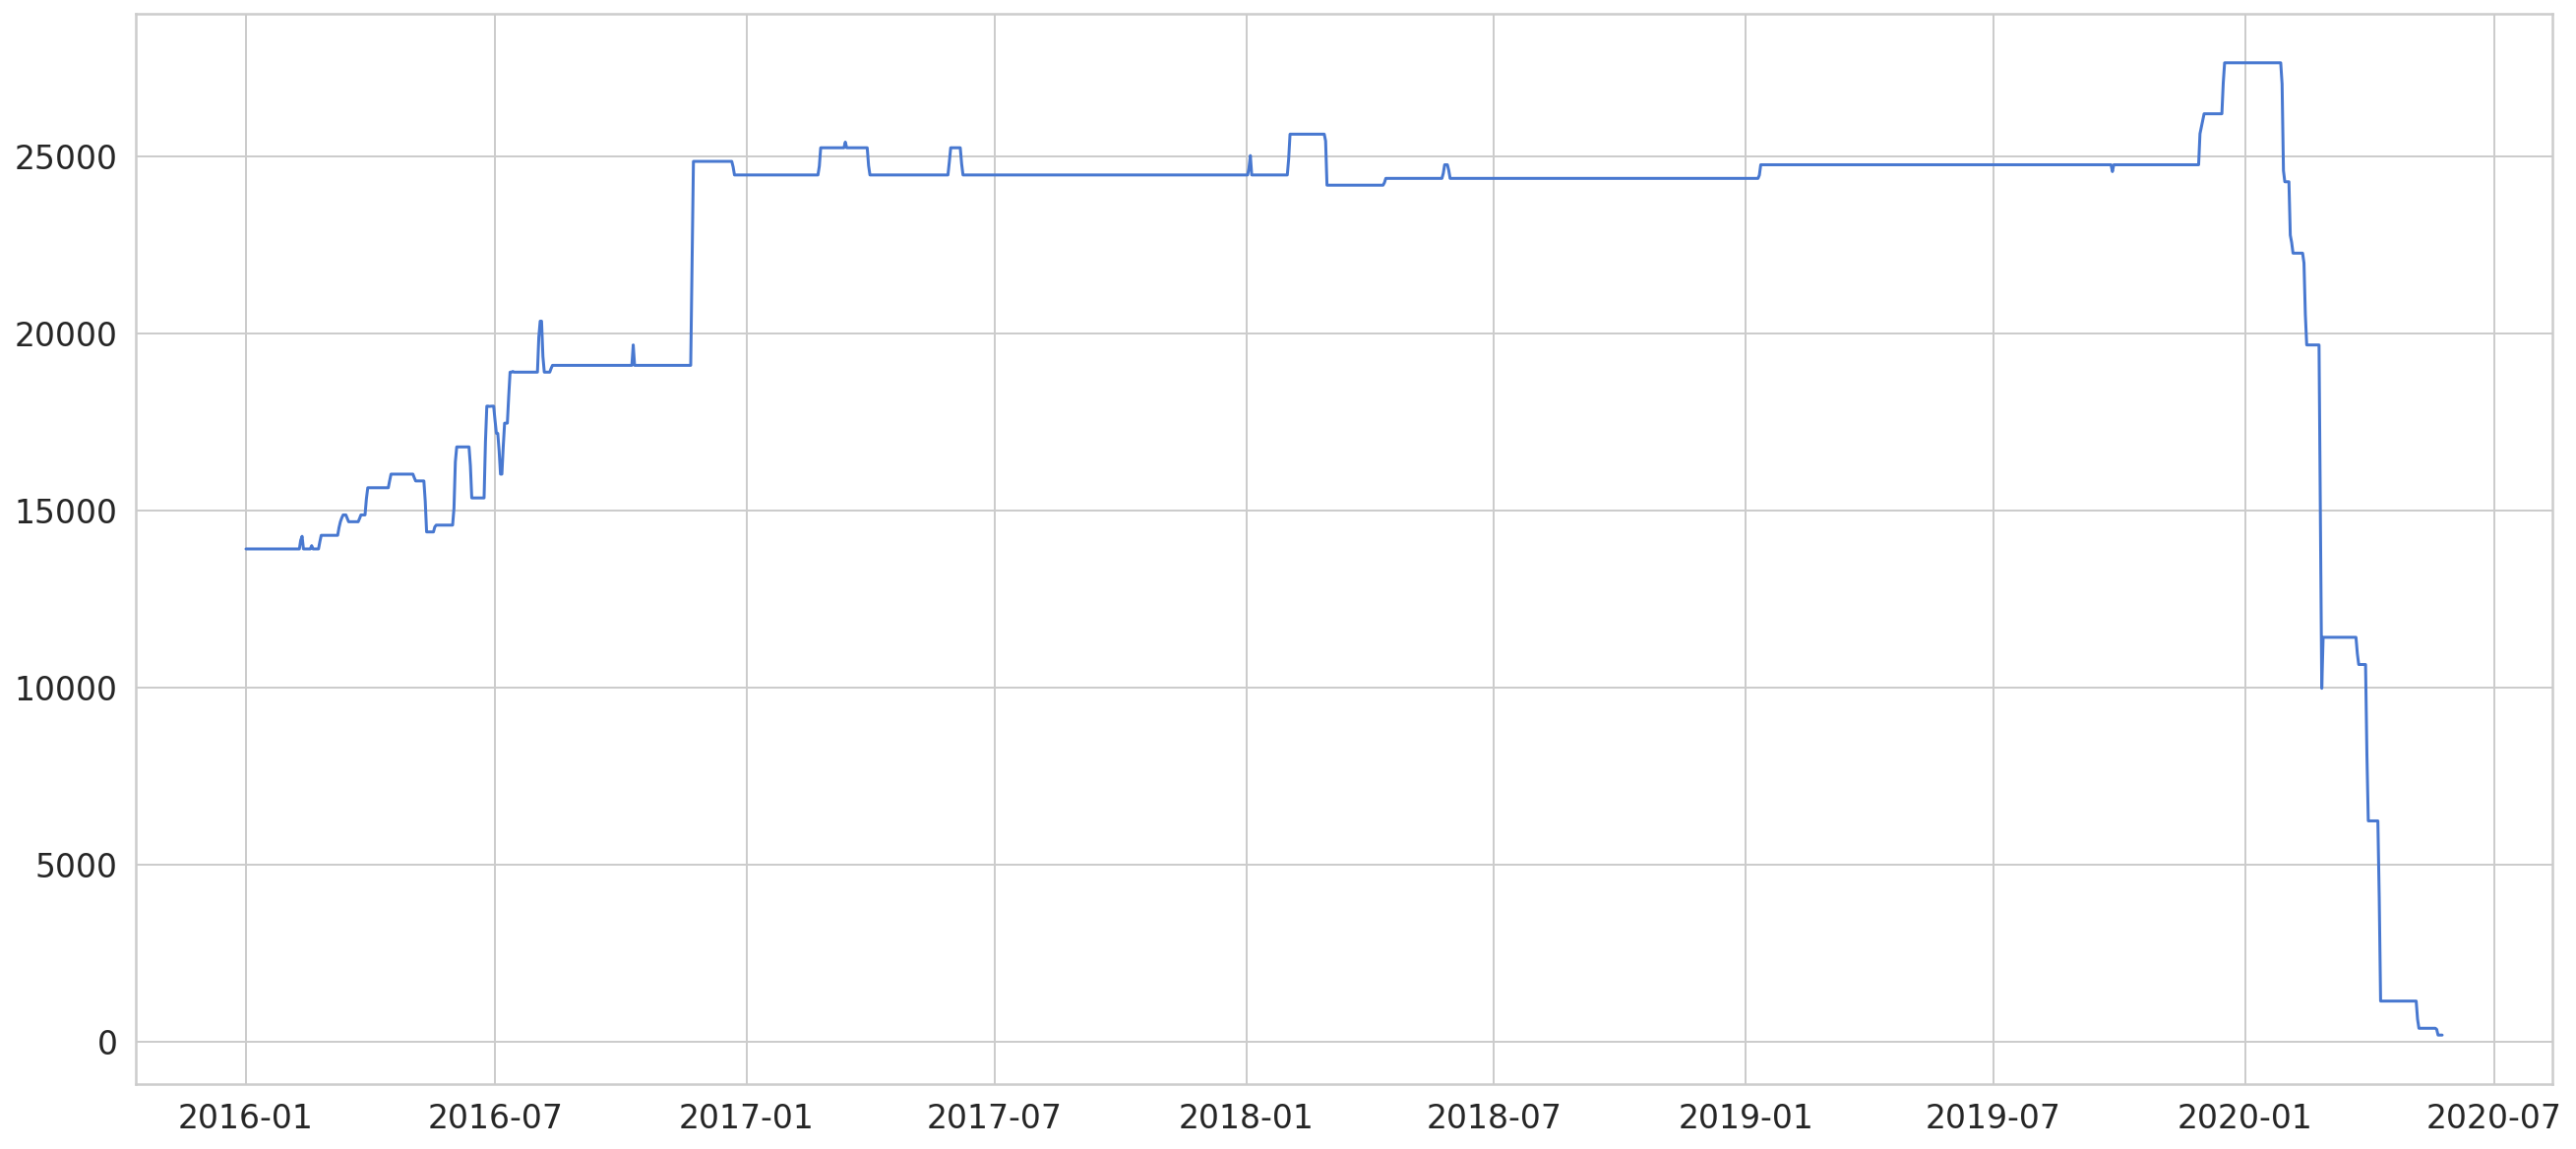

In [43]:
plt.plot(dataset.index,dataset.acct_ttl_unit_hours)

## split the data

In [46]:
train_size = int(len(dataset)*0.9)
test_size = len(dataset) - train_size

train, test = dataset.iloc[0:train_size],dataset.iloc[train_size:len(dataset)]
print(train.shape,test.shape)

(1442, 1) (161, 1)


## scale the data

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['acct_ttl_unit_hours']])

In [50]:
#apply transformation
train['acct_ttl_unit_hours'] = scaler.transform(train[['acct_ttl_unit_hours']])
test['acct_ttl_unit_hours'] = scaler.transform(test[['acct_ttl_unit_hours']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
train.head()

,acct_ttl_unit_hours
usage_date,
2016-01-01 00:00:00+00:00,-2.57442
2016-01-02 00:00:00+00:00,-2.57442
2016-01-03 00:00:00+00:00,-2.57442
2016-01-04 00:00:00+00:00,-2.57442
2016-01-05 00:00:00+00:00,-2.57442


In [52]:
def create_dataset(X,y,time_steps=1):
    Xs, ys = [],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [53]:
TIME_STEPS = 30

X_train, y_train = create_dataset(train[['acct_ttl_unit_hours']],train.acct_ttl_unit_hours,TIME_STEPS)
X_test, y_test = create_dataset(test[['acct_ttl_unit_hours']],test.acct_ttl_unit_hours,TIME_STEPS)

In [54]:
X_train.shape

(1412, 30, 1)

# LSTM Autoencoder

In [55]:
#idea use LSTM to fit time series, when error(pred-actual) exceeds a threshold, label as anomaly

In [56]:
model = keras.Sequential()

#first layer
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1],X_train.shape[2])
))

#add regularization layer
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(
    units=64,
    return_sequences=True
))

#add another regularization layer
model.add(keras.layers.Dropout(rate=0.2))

#add time-distributed layer for anomaly detection
model.add(keras.layers.TimeDistributed(keras.layers.Dense(
   units=X_train.shape[2]
)))

model.compile(loss='mae', optimizer='adam')

In [57]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
    )

Epoch 1/10
40/40 [==============================] - 2s 52ms/step - loss: 0.3479 - val_loss: 0.0778
Epoch 2/10
40/40 [==============================] - 1s 34ms/step - loss: 0.1388 - val_loss: 0.0519
Epoch 3/10
40/40 [==============================] - 1s 34ms/step - loss: 0.1931 - val_loss: 0.0496
Epoch 4/10
40/40 [==============================] - 1s 33ms/step - loss: 0.2430 - val_loss: 0.0486
Epoch 5/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1219 - val_loss: 0.0447
Epoch 6/10
40/40 [==============================] - 1s 33ms/step - loss: 0.1291 - val_loss: 0.0480
Epoch 7/10
40/40 [==============================] - 1s 33ms/step - loss: 0.1556 - val_loss: 0.0459
Epoch 8/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1387 - val_loss: 0.0387
Epoch 9/10
40/40 [==============================] - 1s 33ms/step - loss: 0.1065 - val_loss: 0.0393
Epoch 10/10
40/40 [==============================] - 1s 33ms/step - loss: 0.1313 - val_loss: 0.0437


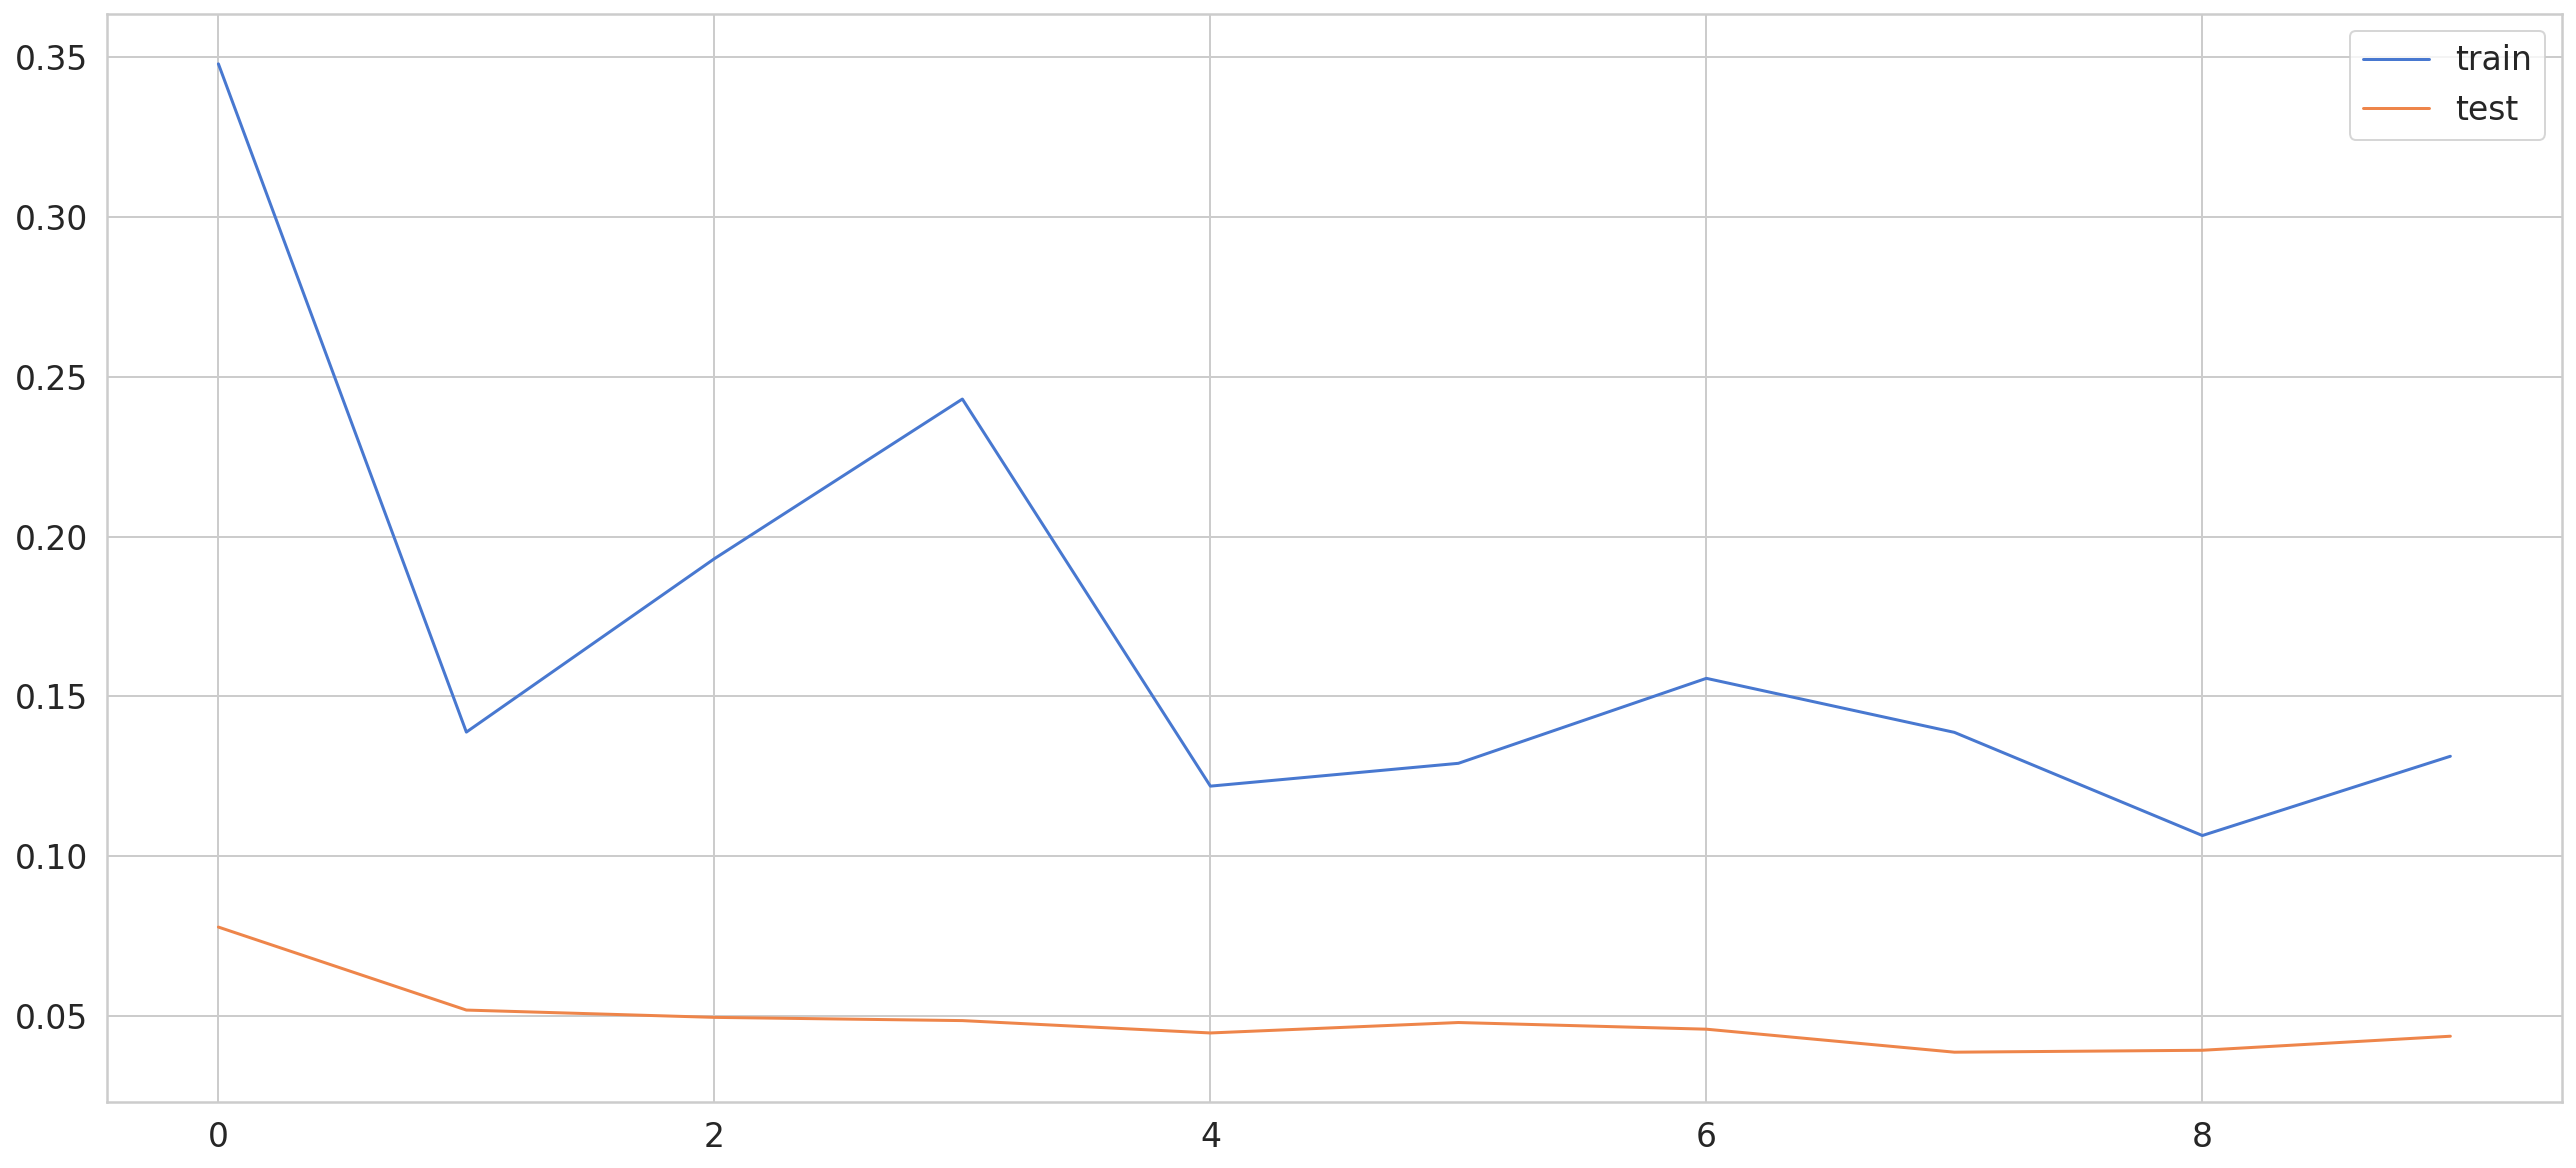

In [58]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend();

In [59]:
X_train_pred = model.predict(X_train)

In [60]:
train_mae_loss = np.mean(np.abs(X_train_pred,X_train),axis=1)

In [61]:
train_mae_loss.shape

(1412, 1)

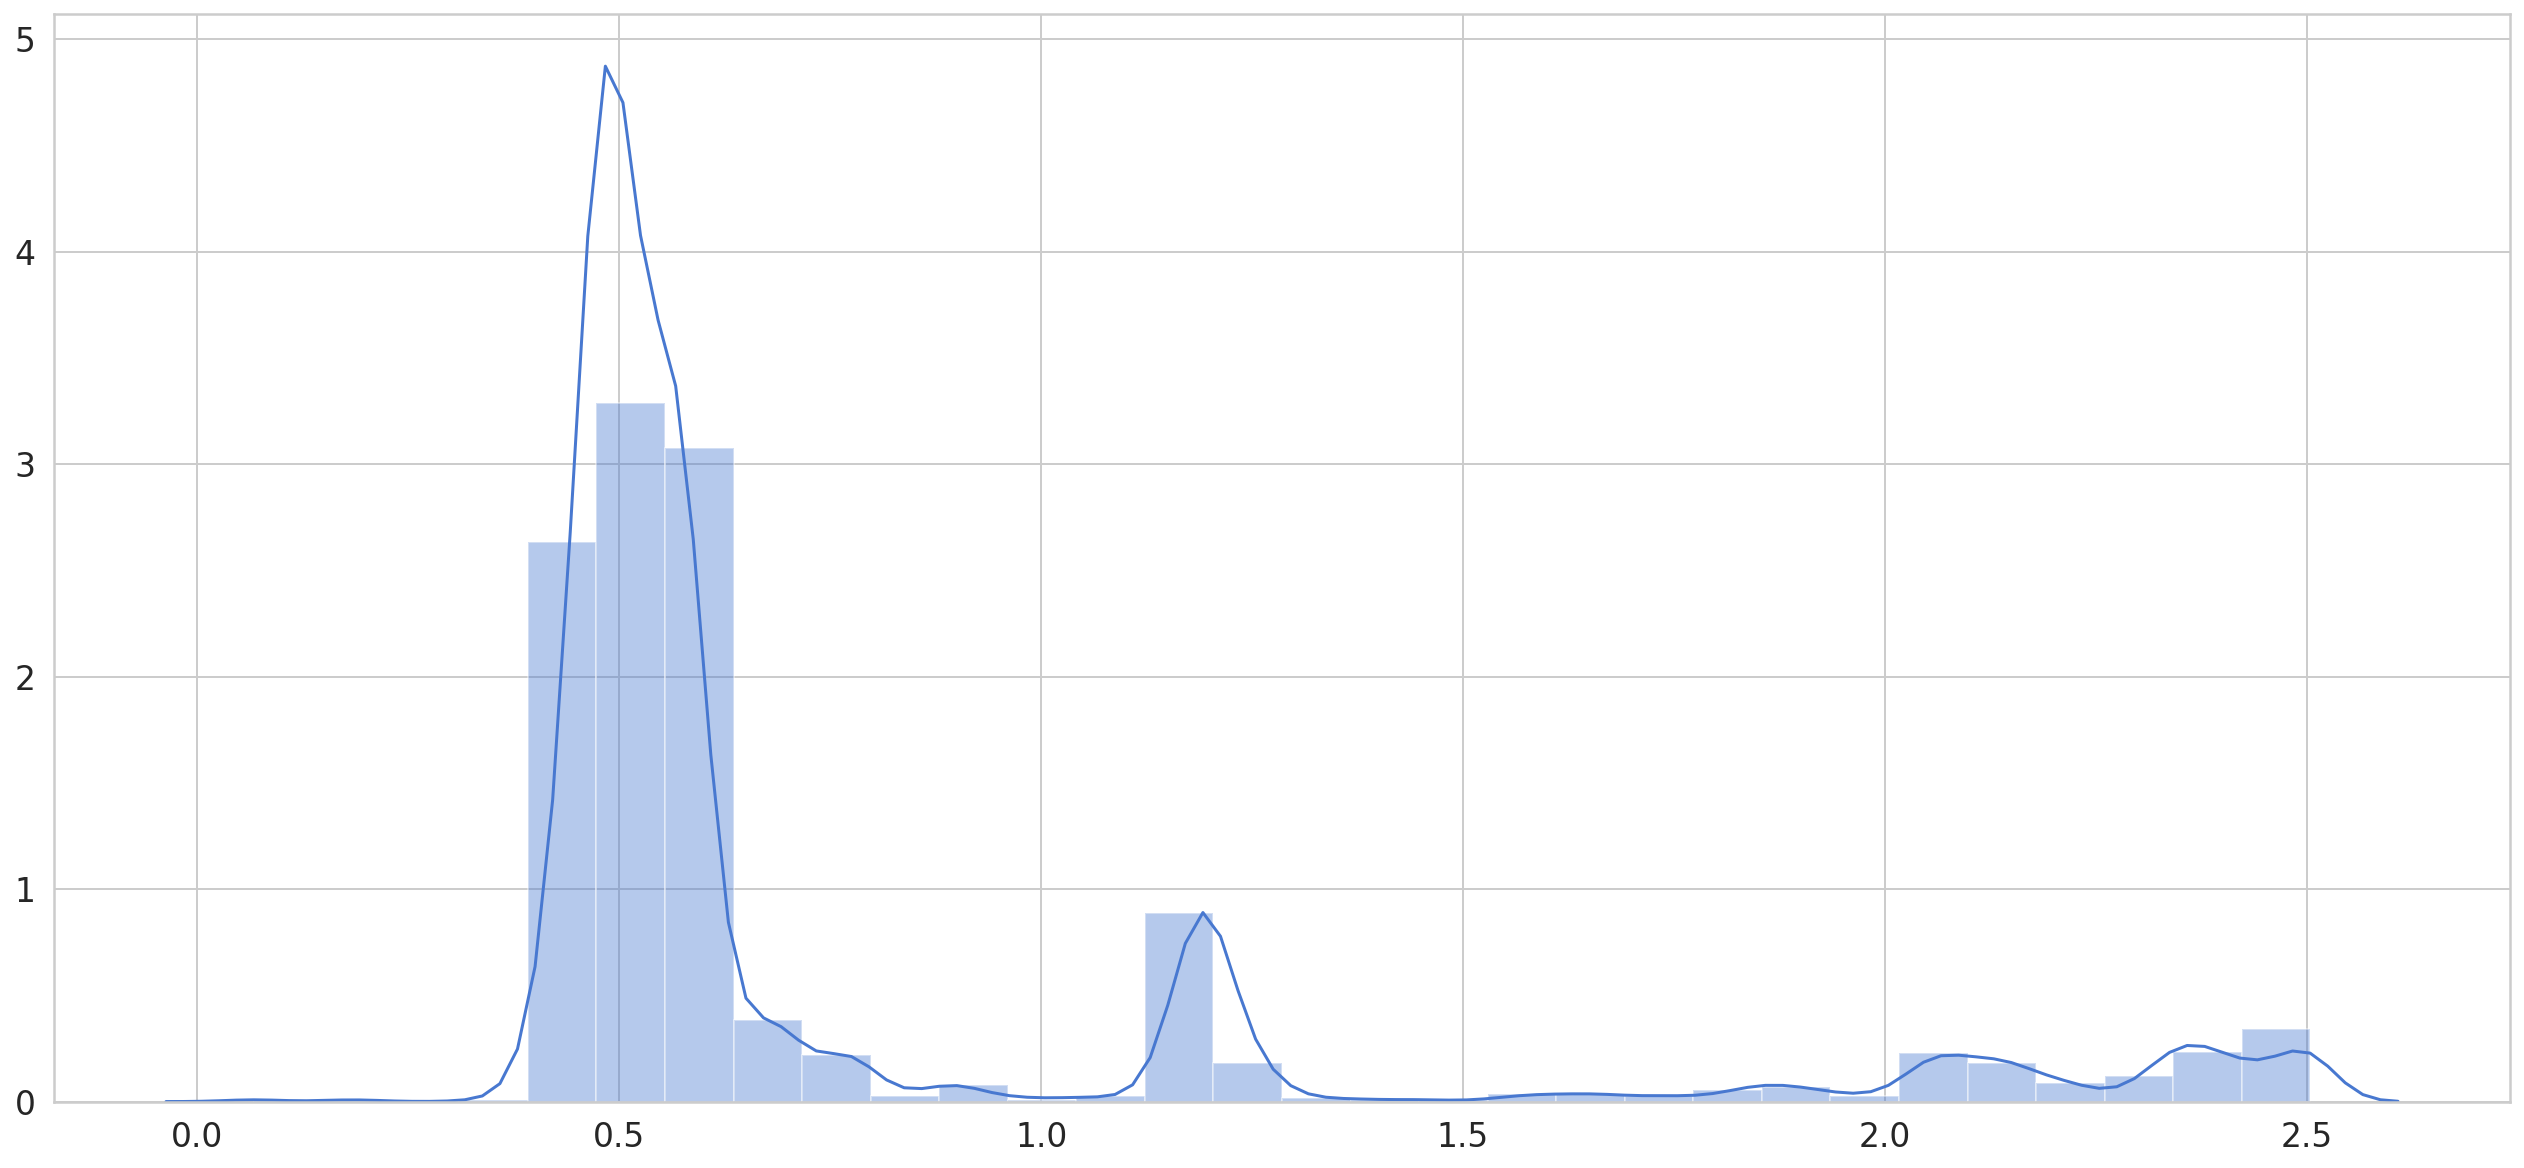

In [63]:
sns.distplot(train_mae_loss,bins=30,kde=True)

In [64]:
### Do the same for the test set

In [65]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred,X_test),axis=1)

In [70]:
THRESHOLD = 1.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['acct_ttl_unit_hours'] = test[TIME_STEPS:].acct_ttl_unit_hours

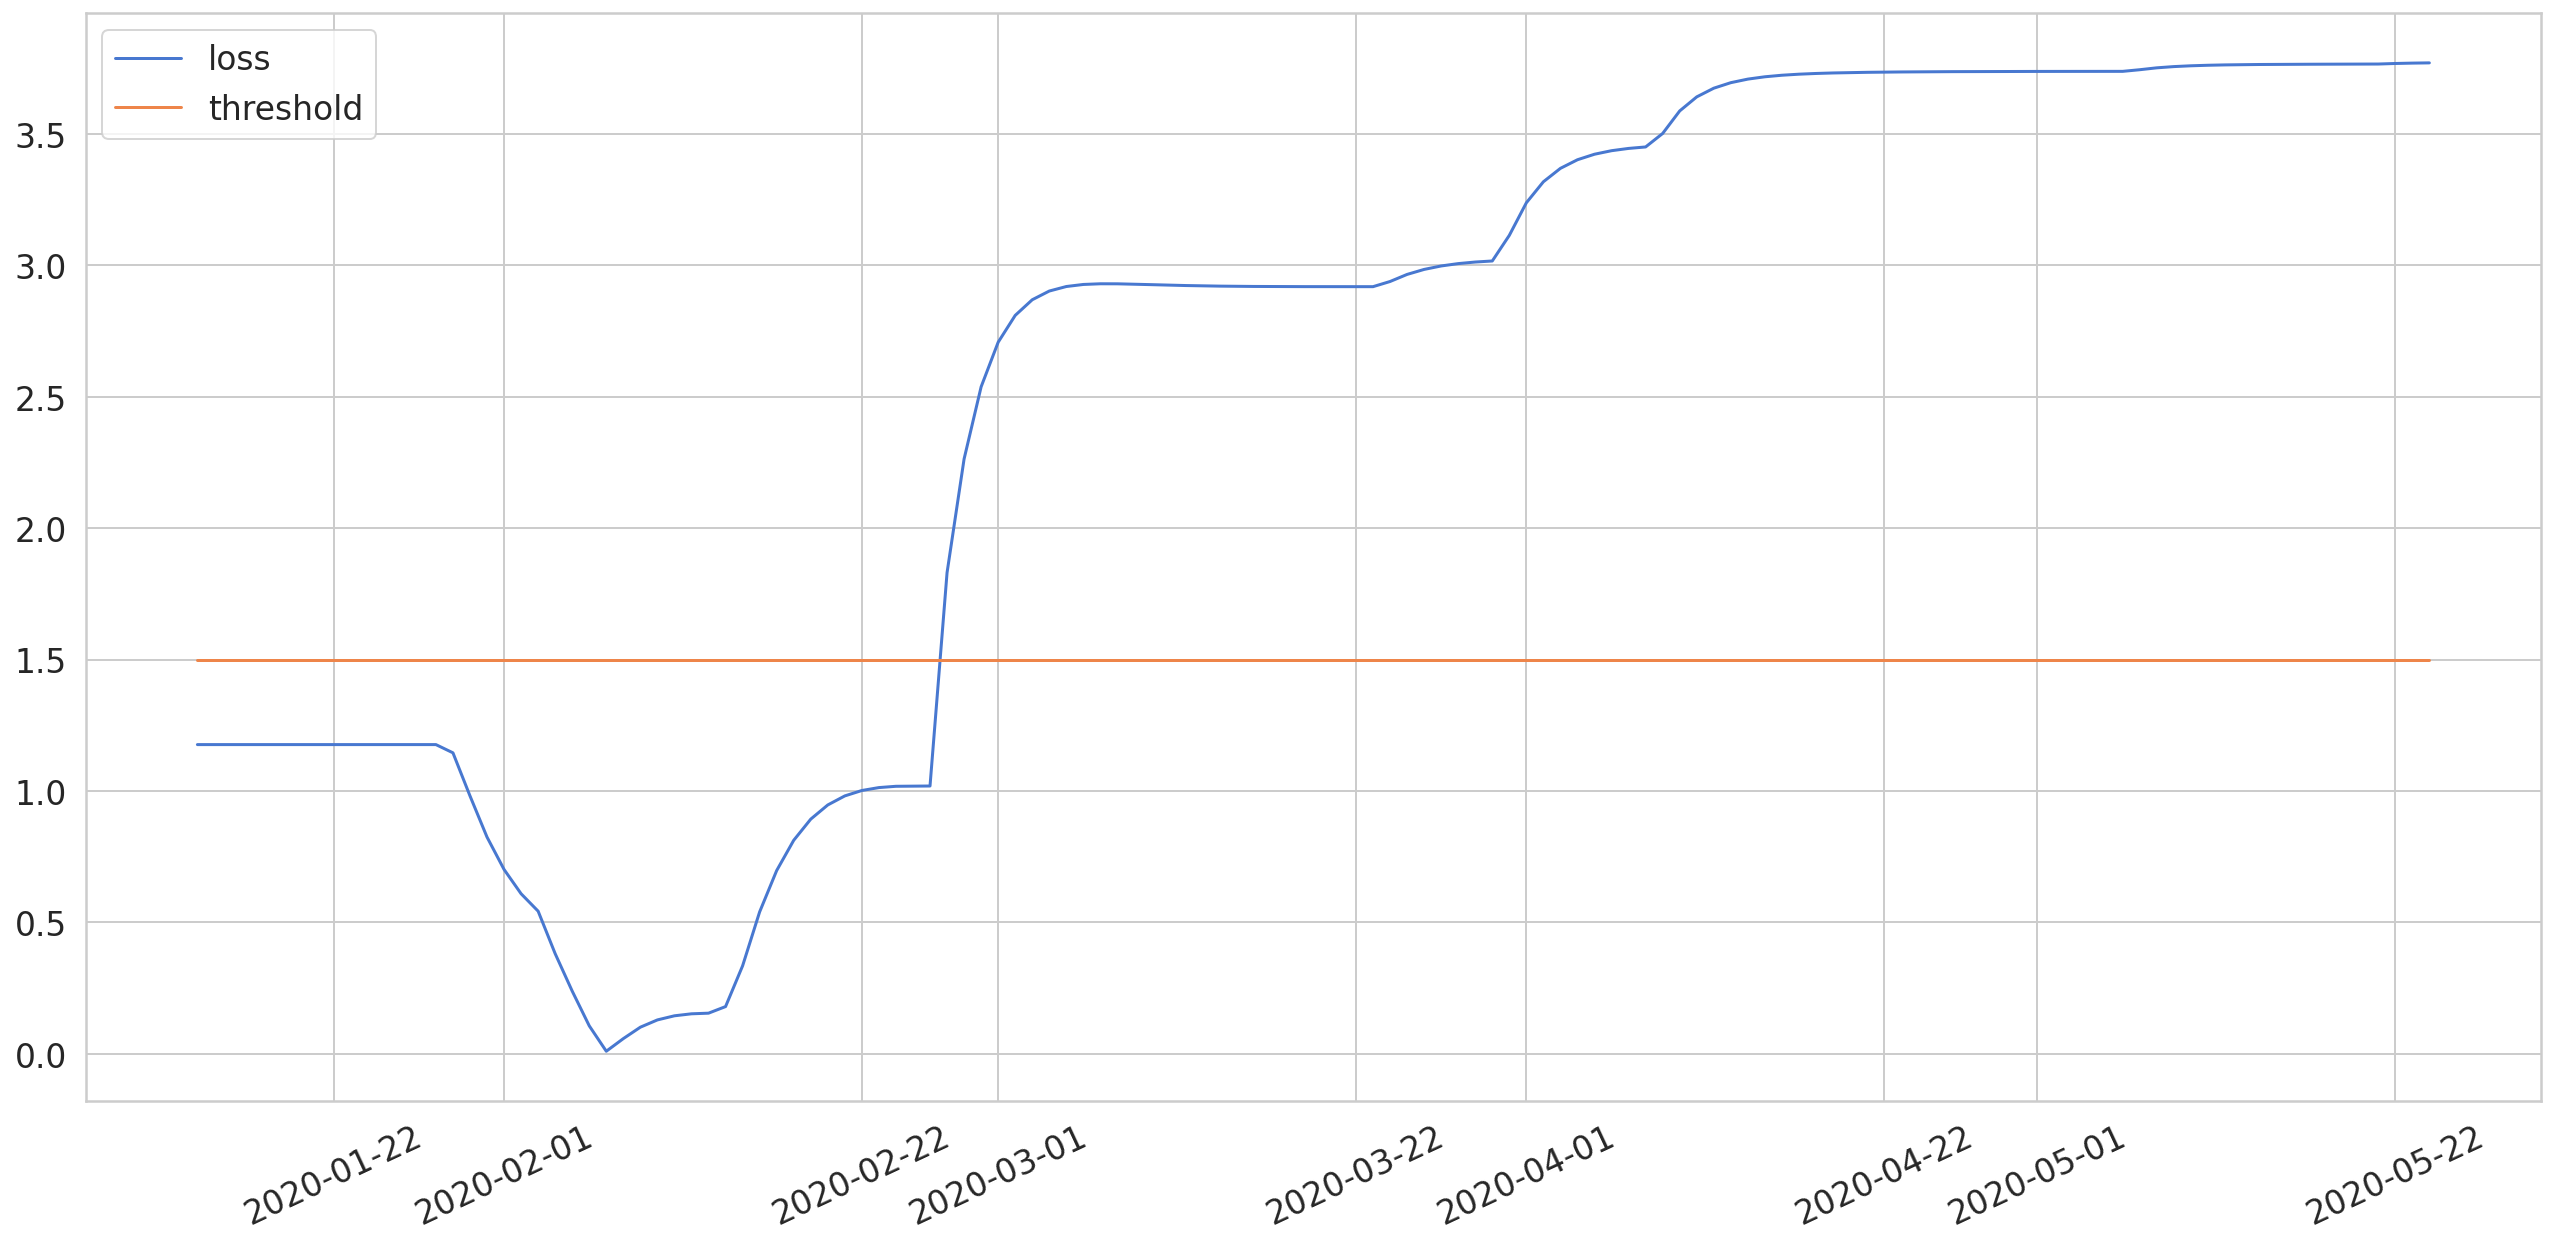

In [71]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [72]:
#create anomalies dataset
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,acct_ttl_unit_hours
usage_date,,,,
2020-02-27 00:00:00+00:00,1.830358,1.5,True,-3.295072
2020-02-28 00:00:00+00:00,2.262872,1.5,True,-3.295072
2020-02-29 00:00:00+00:00,2.537283,1.5,True,-3.295072
2020-03-01 00:00:00+00:00,2.706848,1.5,True,-3.295072
2020-03-02 00:00:00+00:00,2.808902,1.5,True,-3.295072


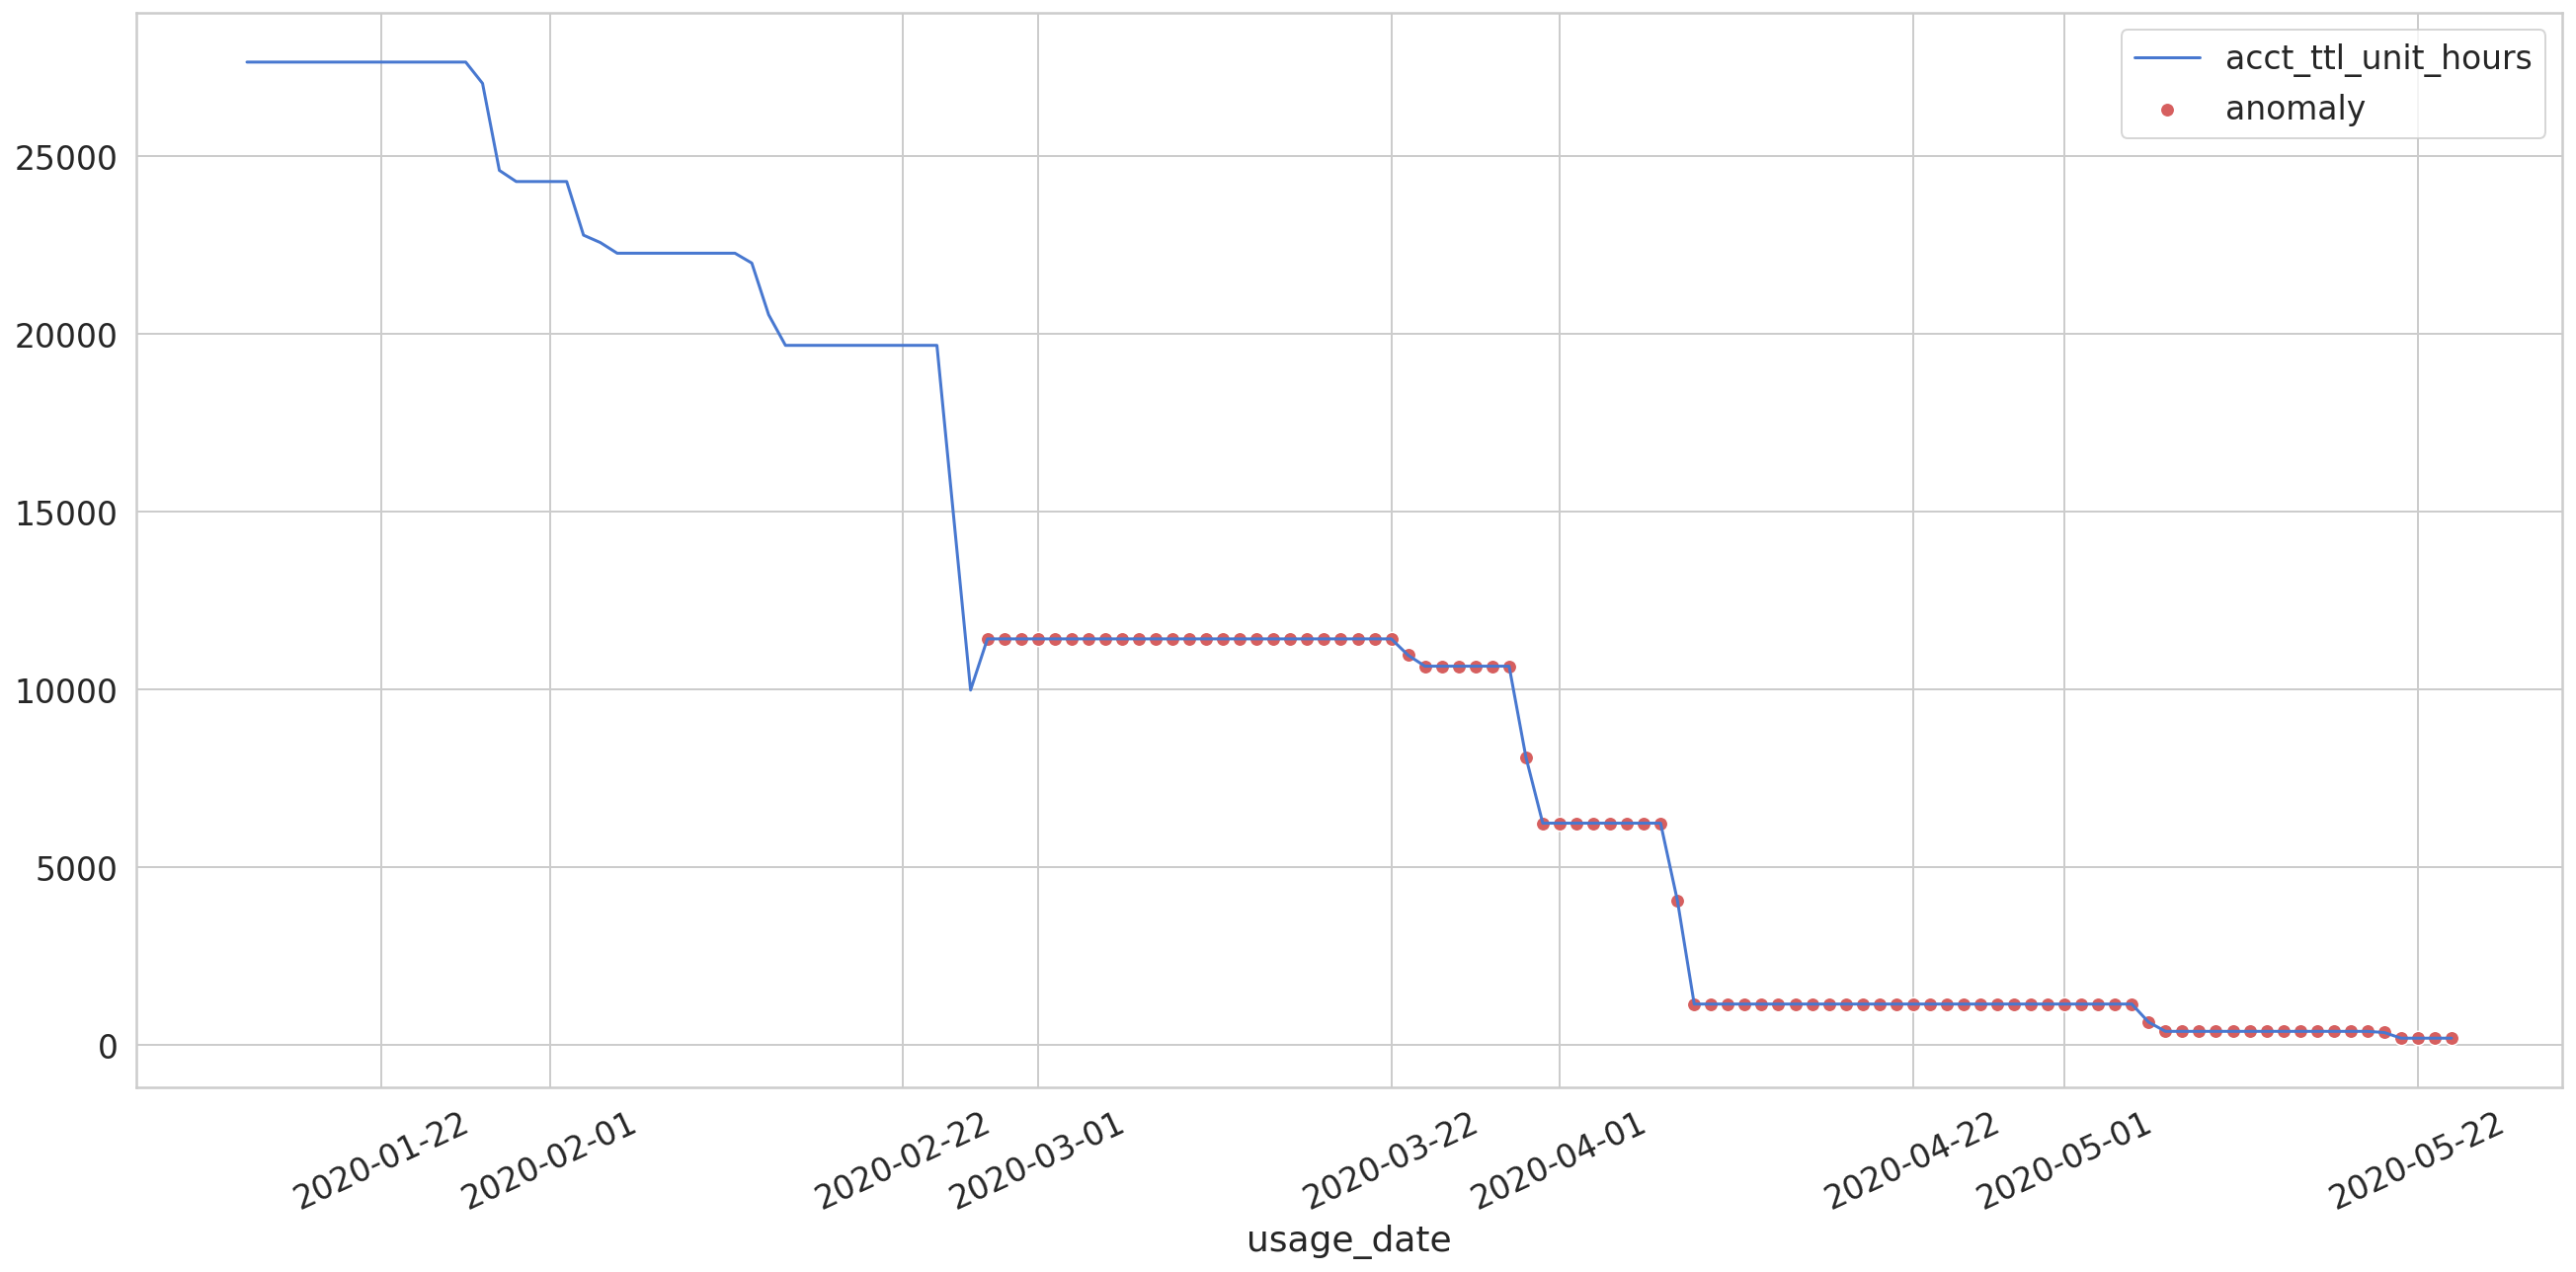

In [73]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:].acct_ttl_unit_hours),
    label='acct_ttl_unit_hours'
)

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies.acct_ttl_unit_hours),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
)

plt.xticks(rotation=25)
plt.legend();